In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy import stats
import seaborn as sns

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")

In [4]:
def transform_features(df):
    # Dropping columns with a % of missing values higher than 5
    mv_df = df.isnull().sum()
    above_5 = mv_df[(mv_df/len(df) > 0.05)]
    df = df.drop(above_5.index, axis=1)
    
    # Selecting text columns and dropping any columns with missing values
    text_cols = df.select_dtypes(include=['object']).columns
    drop_cols = df[text_cols].isnull().sum() > 0
    text_df = df.drop(drop_cols.index, axis=1)
    for col in text_df.columns:
        df[col] = text_df[col]
    
    # Selecting numeric columns and using mode to fill missing values
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    modals = df[numeric_cols].mode()
    numeric_df = df[numeric_cols].fillna(value=modals.iloc[0])
    # Assigning back to original dataframe
    for col in numeric_df.columns:
        df[col] = numeric_df[col]
    
    # Creating more meaningful features from original ones
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    
    # Dropping rows with inconsistent values (in this case, negative)
    df = df[df['Years Before Sale'] >= 0]
    df = df[df['Years Since Remod'] >= 0]
    
    # Dropping unuseful and redundant columns
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    df = df.drop(["PID", "Order"], axis=1)
    df = df.drop(["Mo Sold"], axis=1)
    
    return df

transform_features(df).isnull().sum()

MS SubClass           0
MS Zoning             0
Lot Area              0
Street                0
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type         23
Mas Vnr Area          0
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            80
Bsmt Cond            80
Bsmt Exposure        83
BsmtFin Type 1       80
BsmtFin SF 1          0
                     ..
1st Flr SF            0
2nd Flr SF            0
Low Qual Fin SF       0
Gr Liv Area           0
Bsmt Full Bath        0
Bsmt Half Bath        0
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual    

MS Zoning                  0
Street                     0
Lot Shape                  0
Land Contour               0
Utilities                  0
Lot Config                 0
Land Slope                 0
Condition 1                0
Condition 2                0
Bldg Type                  0
House Style                0
Overall Qual               0
Roof Style                 0
Roof Matl                  0
Mas Vnr Type              23
Mas Vnr Area               0
Exter Qual                 0
Exter Cond                 0
Foundation                 0
Bsmt Qual                 80
Bsmt Cond                 80
Bsmt Exposure             83
BsmtFin Type 1            80
BsmtFin SF 1               0
BsmtFin Type 2            81
Total Bsmt SF              0
Heating                    0
Heating QC                 0
Central Air                0
Electrical                 1
                          ..
Kitchen Qual_Gd            0
Kitchen Qual_Po            0
Kitchen Qual_TA            0
Functional_Maj

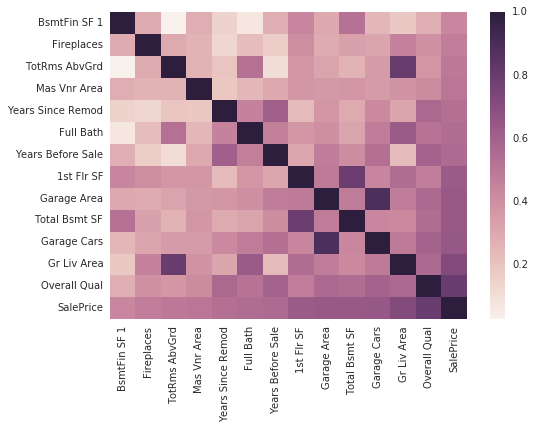

In [5]:
def select_features(df):
    # Selecting features that correlate well with (> 0.4) the target attribute
    corr_mat = df.corr()
    sorted_corrs = np.absolute(corr_mat['SalePrice']).sort_values()
    strong_corrs = sorted_corrs[sorted_corrs > 0.4].index
    weak_corrs = sorted_corrs[sorted_corrs <= 0.4].index
    sns.heatmap(np.absolute(df[strong_corrs].corr()))
    df = df.drop(weak_corrs, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street",
                    "Alley", "Land Contour", "Lot Config",
                    "Neighborhood", "Condition 1", "Condition 2",
                    "Bldg Type", "House Style", "Roof Style",
                    "Roof Matl", "Exterior 1st", "Exterior 2nd",
                    "Mas Vnr Type", "Foundation", "Heating",
                    "Central Air", "Garage Type", "Misc Feature",
                    "Sale Type", "Sale Condition"]

    #transform_cat_cols = []
    #for col in nominal_features:
    #    if col in df.columns:
    #        transform_cat_cols.append(col)
    #uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    #drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    #df = df.drop(drop_nonuniq_cols, axis=1)
    
    for col in df.columns:
        if col in nominal_features:
            df[col] = df[col].astype('category', copy=True)
            if len(df[col].value_counts()) > 10:
                df = df.drop(col, axis=1)

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category', copy=True)
    
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

df2 = transform_features(df)
select_features(df2).isnull().sum()

In [12]:
def train_and_test(df, k=0):
    numeric_cols = df.select_dtypes(include=['int', 'float'])
    features = numeric_cols.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        rmse = mean_squared_error(test["SalePrice"], predictions) ** (1/2)
    
    elif k == 1:
        shuf_df = df.sample(frac=1)
        fold_one = df[:1460]
        fold_two = df[1460:]
        lr.fit(fold_one[features], fold_one["SalePrice"])
        predictions1 = lr.predict(fold_two[features])
        
        lr.fit(fold_two[features], fold_two['SalePrice'])
        predictions2 = lr.predict(fold_one[features])
        
        rmse1 = mean_squared_error(fold_two['SalePrice'], predictions1)
        rmse2 = mean_squared_error(fold_one['SalePrice'], predictions2)
        rmse = np.mean(['rmse1', 'rmse2'])
        
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        
        mses = cross_val_score(lr, df[features], df['SalePrice'], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse = np.mean(rmses)
        rmse = avg_rmse
        
    return rmse

32740.932204622295

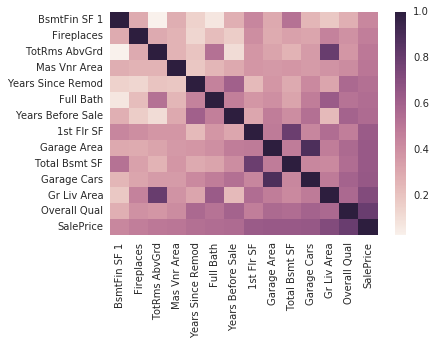

In [13]:
transform_df = transform_features(df)
#print(transform_df.isnull().sum())
filtered_df = select_features(transform_df)
#print(transform_df.isnull().sum())
train_and_test(filtered_df, k=4)

In [627]:
mv_df = df.isnull().sum()
# print(mv_df)
above_5 = mv_df[(mv_df/len(df) > 0.05)]
below_5 = df.drop(above_5.index, axis=1)

In [628]:
num_below_5 = below_5.select_dtypes(include=['int', 'float'])
modals = num_below_5.mode()
# print(num_below_5.isnull().sum().sort_values())
num_below_5 = num_below_5.fillna(value=modals.iloc[0])
print(num_below_5.isnull().sum())

Order              0
PID                0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64


In [629]:
num_below_5['Years Before Sale'] = num_below_5['Yr Sold'] - num_below_5['Year Built']
num_below_5['Years Since Remod'] = num_below_5['Yr Sold'] - num_below_5['Year Remod/Add']
print(num_below_5.shape)
num_below_5 = num_below_5[num_below_5['Years Before Sale'] >= 0]
print(num_below_5.shape)
num_below_5 = num_below_5[num_below_5['Years Since Remod'] >= 0]
print(num_below_5.shape)
num_below_5 = num_below_5.drop(["Year Built", "Year Remod/Add"], axis = 1)
print(num_below_5.shape)
num_below_5 = num_below_5.drop(["PID", "Order"], axis=1)
print(num_below_5.shape)
num_below_5 = num_below_5.drop(["Mo Sold", "Yr Sold"], axis=1)
print(num_below_5.shape)

(2930, 39)
(2929, 39)
(2927, 39)
(2927, 37)
(2927, 35)
(2927, 33)


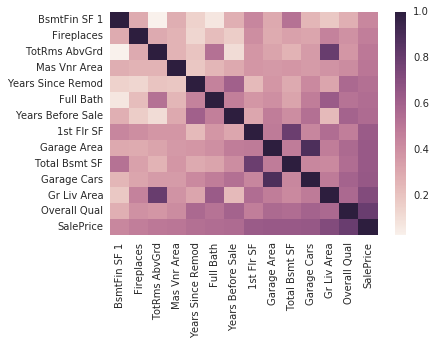

In [630]:
corr_mat = num_below_5.corr()
# print(corr_mat.info())
sorted_corrs = np.absolute(corr_mat['SalePrice']).sort_values()
strong_corrs = sorted_corrs[sorted_corrs > 0.4].index
sns.heatmap(np.absolute(num_below_5[strong_corrs].corr()))

In [631]:
print(num_below_5.shape)
num_below_5 = num_below_5[strong_corrs]
print(num_below_5.shape)

(2927, 33)
(2927, 14)


In [632]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street",
                    "Alley", "Land Contour", "Lot Config",
                    "Neighborhood", "Condition 1", "Condition 2",
                    "Bldg Type", "House Style", "Roof Style",
                    "Roof Matl", "Exterior 1st", "Exterior 2nd",
                    "Mas Vnr Type", "Foundation", "Heating",
                    "Central Air", "Garage Type", "Misc Feature",
                    "Sale Type", "Sale Condition"]

num_nominal_feats = df[nominal_features].select_dtypes(include=['int', 'float']).columns

for col in nominal_features:
    df[col] = df[col].astype('category', copy=True)
    if len(df[col].value_counts()) > 10:
        df = df.drop(col, axis=1)
    
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category', copy=True)
        
print(df.shape)
df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
print(df.shape)
    
# for col in df.select_dtypes(include=['category']).columns:
#    per_value_counts = df[col].value_counts()/df.shape[0]

(2930, 77)
(2930, 284)
